<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/object-detection/Object_Detection_Inference_With_TF_Hub_Model_And_Object_Detection_API_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

 - This page demoonstrates object detection using a TF HUB pre-trained model.
The model can be selected from a list of models, all trained with MS-COCO dataset.

- The detections are annotated with bounding boxes and text, produced by python code.

- In an example which follows, annotations are produced by `Object Detection API`.


## Installing the Tensorflow 2 Object Detection API

We start by installing Object Detection API which is used in this example for annotating detections' bounding boxes and text.



###  Clone the model garden repo



In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3158, done.
remote: Counting objects: 100% (3158/3158), done.
remote: Compressing objects: 100% (2688/2688), done.
remote: Total 3158 (delta 808), reused 1323 (delta 426), pack-reused 0
Receiving objects: 100% (3158/3158), 33.40 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (808/808), done.


###Intall Object Detection API

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1684828 sha256=20728c911e25bc3760ca86f355c3409f4cf18657fcfb05c6bd14d59da22fd3cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4szhob_/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=ab62c49b7fc00197774f2debd478a5638de6869fa170c40fc7095b9d6ca24dc6
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=35a5eb78dd9f8b01f27b6bdf4e8909a0e6e0c32c2b50562d02823c5627bbbafd
  Stored in directory: /root/.cache/pip/w



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


#### Import the dependencies - needed later

**label_map_util** - for mapping class index to class name

**viz_utils** - to visualize detections bounding boxes and text annotations.




In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import ops as utils_ops

%matplotlib inline

## Import Packages

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO


import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

print(tf.__version__)

print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.7.0
The following GPU devices are available: /device:GPU:0


## Select A Model From TensorFlow Hub

#####About TensorFlow Hub:
- TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere
- Select from a list of TF HUB Detection Models

#####About Below Selection Listed TF Hub Models:

 - All models were trained with MS-COCO with 80 class categories.

- Constraints on Input Images:
 - All models accepts any image size.
 - The input for all models is a tensor with shape [1, height, width, 3] 
 - Values in range [0, 255]
 - Data type tf.uint8 (Numpy also works, can be float)
 - All models don't support batching






#####The Models List:

In [ ]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}



In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]
# model_handle ='https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1' # ronen!!
print('Selected model:'+ model_display_name)
print(f'Model Handle at TensorFlow Hub: {}')

Selected model:CenterNet HourGlass104 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1


##Load the Selected Model

In [ ]:
hub_model = hub.load(model_handle)

## Detector Function

Run Detector with the downloaded image.

The Detector returns a dictionary which contains the following values:


**num_detections**: a tf.int tensor with only one value, the number of detections [N].

**detection_boxes**: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].

**detection_classes**: a tf.int tensor of shape [N] containing detection class index from the label file.

**detection_scores**: a tf.float32 tensor of shape [N] containing detection scores.

**raw_detection_boxes**: a tf.float32 tensor of shape [1, M, 4] containing decoded detection boxes without Non-Max suppression. M is the number of raw detections.

**raw_detection_scores:** a tf.float32 tensor of shape [1, M, 90] and contains class score logits for raw detection boxes. M is the number of raw detections.

**detection_anchor_indices**: a tf.float32 tensor of shape [N] and contains the anchor indices of the detections after NMS.

**detection_multiclass_scores**: a tf.float32 tensor of shape [1, N, 90] and contains class score distribution (including background) for detection boxes in the image including background class.



In [ ]:
def run_detector(detector, img):
  result = detector(img)
  detections = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(detections["detection_scores"]))
  return detections

## Generate label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

## Load Target Image

####Select Target Image

In [ ]:
def download_image(image_url, scale_down_factor=1):
  response = urlopen(image_url)
  image = response.read()
  image = BytesIO(image)
  image = Image.open(image)

  img = np.array(image)
  width = image.width//scale_down_factor
  height = image.height//scale_down_factor
  img = tf.image.resize(img, [height, width], antialias=True, method='nearest')
  img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

  return img



In [ ]:
IMAGES_FOR_TEST = {
  # By Marc Ryckaert, Source: https://commons.wikimedia.org/wiki/File:Seagulls_Miami_Beach_R01.jpg
  'Seagulls': 'https://upload.wikimedia.org/wikipedia/commons/2/21/Seagulls_Miami_Beach_R01.jpg',
  # By Mostafa Meraji, source: https://commons.wikimedia.org/wiki/File:Animals_of_Iran_06.jpg  
  'Flying Birds': 'https://upload.wikimedia.org/wikipedia/commons/f/fb/Animals_of_Iran_06.jpg',
  # By Touhid biplob, Source: https://commons.wikimedia.org/wiki/File:Running_zebra.jpg
  'Zebras': 'https://upload.wikimedia.org/wikipedia/commons/8/8f/Running_zebra.jpg',
  # By Chris Allen, Source: https://commons.wikimedia.org/wiki/File:Company_housing,_Street_-_geograph.org.uk_-_3019550.jpg
  'Street': 'https://upload.wikimedia.org/wikipedia/commons/2/20/Company_housing%2C_Street_-_geograph.org.uk_-_3019550.jpg'
}


##Execute Detection Session


####Set Execution Params

In [ ]:
#@title Set Execution Params{ run: "auto" }
selected_image = 'Street' #@param ['Seagulls', 'Flying Birds', 'Zebras', 'Street']  { run: "auto" }
image_url = IMAGES_FOR_TEST[selected_image]
max_boxes_to_draw = 50 #@param {type:"integer"}

min_score_thresh = 20 #@param {type:"slider", min:0, max:100, step:1}

image_scale_down_factor = 1 #@param {type:"slider", min:1, max:8, step:1}



####Exceute Detection

Found 1 objects.
num_detections: [100.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


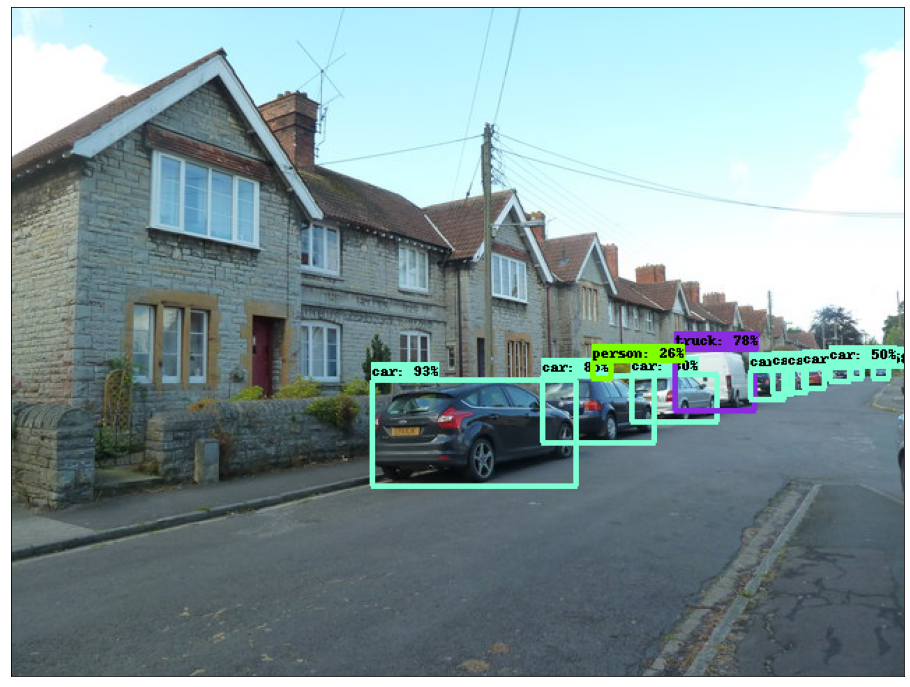

In [ ]:
img = download_image(image_url, image_scale_down_factor)
detections = run_detector(hub_model, img)
num_detections = detections['num_detections']
print(f'num_detections: {num_detections}')
class_id = detections['detection_classes'].squeeze()
bboxes = detections['detection_boxes'].squeeze()
scores = detections['detection_scores'].squeeze()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'].squeeze()
  keypoint_scores = detections['detection_keypoint_scores'].squeeze()


annotated_image = viz_utils.visualize_boxes_and_labels_on_image_array(
    img.numpy().squeeze(),
    bboxes, 
    (class_id).astype(int), 
    scores,
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh/100,
    agnostic_mode=False,
    keypoints=keypoints,
    keypoint_scores=keypoint_scores,
    keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS
)

fig = plt.figure(figsize=(16,27))
plt.yticks([])
plt.xticks([])
ax = fig.add_subplot(1, 1, 1)
ax.imshow(annotated_image)


##More Execution Outputs

Here below are the outputs plotted for the other input images


**Seagulls_Miami_Beach**

By Marc Ryckaert

Source: https://commons.wikimedia.org/wiki/File:Seagulls_Miami_Beach_R01.jpg



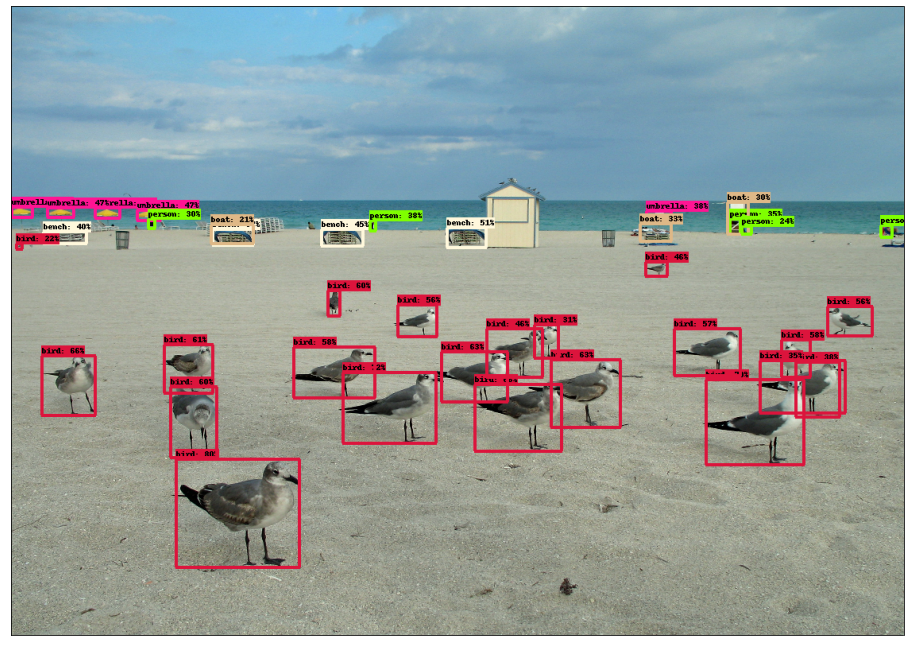

**Flying Birds**

By Mostafa Meraji

Source https://commons.wikimedia.org/wiki/File:Animals_of_Iran_06.jpg

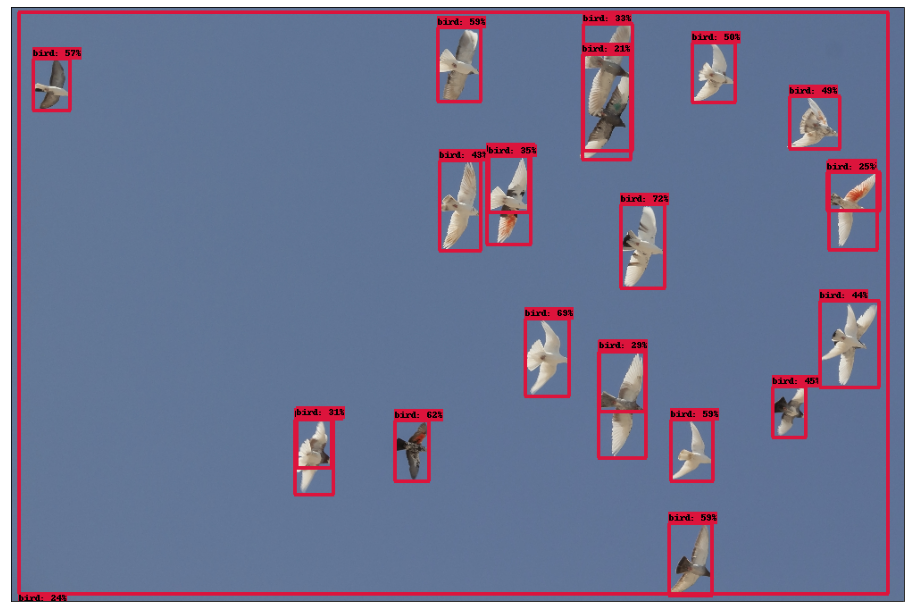

**Running_zebra**

By Touhid biplob

Source: https://commons.wikimedia.org/wiki/File:Running_zebra.jpg


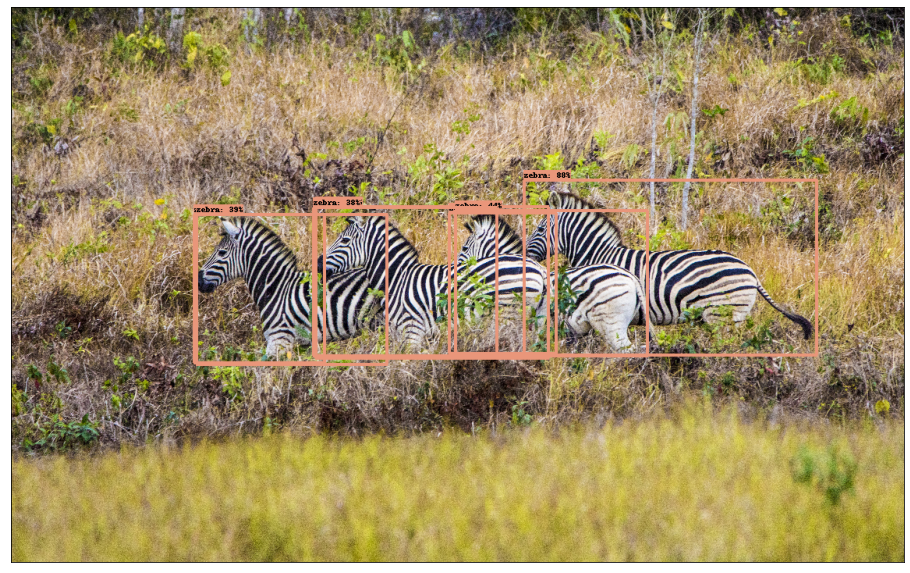